<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/main/Claude_improved_CNN(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================
# PART 1: Data Loading (Keep your existing code)
# ============================================
# Install required package
!pip install gdown

import zipfile, os
import random
from glob import glob
import shutil
from PIL import Image
# import urllib.request # No longer needed

# dropbox_link = "https://www.dropbox.com/scl/fo/mauujpylbyf5r9md6mw2v/AOHvMi9ATu7smWgBeJgeN78?rlkey=oiyod9ack4n1og6z68lrk8nq4&e=2&st=iv1hz2rm&dl=1" # Use direct download link or gdown

# print("Downloading from Dropbox...")
# urllib.request.urlretrieve(dropbox_link, "patches.zip") # This might not follow redirects
# print("Download complete!")

# Use gdown to download directly
dropbox_id = "AOHvMi9ATu7smWgBeJgeN78" # Extracted from the Dropbox shared link
output_filename = "patches.zip"

print(f"Downloading from Dropbox using gdown ID: {dropbox_id}")
!gdown --id "{dropbox_id}" -O "{output_filename}"
print("Download complete!")


print("Extracting files...")
with zipfile.ZipFile(output_filename, 'r') as zip_ref:
    zip_ref.extractall("patches")
print("Extraction complete!")

extract_dir = "/content/patches"

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=AOHvMi9ATu7smWgBeJgeN78

but Gdown can't. Please check connections and permissions.
Download complete!
Extracting files...


BadZipFile: File is not a zip file

In [ ]:
# ============================================
# PART 2: Dataset Creation - OPTIMIZED
# ============================================
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import mixed_precision
import gc

# CRITICAL: Enable mixed precision to cut RAM usage by ~40%
mixed_precision.set_global_policy('mixed_float16')
print("✓ Mixed precision enabled")

# Parameters - REDUCED BATCH SIZE
data_dir = extract_dir
img_size = (256, 256)
batch_size = 16  # Reduced from 64 - saves significant RAM
seed = 42

# Create splits - NO SAMPLING, use full dataset now!
train_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_test_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Split validation and test
val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Val batches:   {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches:  {tf.data.experimental.cardinality(test_ds)}")



✓ Mixed precision enabled
Found 6000 files belonging to 3 classes.
Using 4800 files for training.
Found 6000 files belonging to 3 classes.
Using 1200 files for validation.
Train batches: 300
Val batches:   38
Test batches:  37


In [ ]:
# ============================================
# PART 3: Data Augmentation & Preprocessing - OPTIMIZED
# ============================================
AUTOTUNE = tf.data.AUTOTUNE

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Data augmentation for training only (aerial imagery specific)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),  # 180 degrees (no preferred orientation)
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess_train(ds):
    """Apply augmentation + normalization to training data"""
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return ds.cache().shuffle(1000).prefetch(AUTOTUNE)

def preprocess_val_test(ds):
    """Only normalization for val/test"""
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return ds.cache().prefetch(AUTOTUNE)

train_ds = preprocess_train(train_ds)
val_ds = preprocess_val_test(val_ds)
test_ds = preprocess_val_test(test_ds)

print("✓ Data pipeline optimized")



✓ Data pipeline optimized


In [ ]:
# ============================================
# PART 4: Model Architecture - OPTIMIZED
# ============================================
from tensorflow.keras import layers, models

# Smaller, more efficient model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size + (3,)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Classification - USING GLOBAL POOLING (huge RAM savings!)
    layers.GlobalAveragePooling2D(),  # Replaces Flatten() + reduces parameters
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax', dtype='float32')  # Force float32 for stability
])

# Compile with moderate learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly reduced
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,043 (433.76 KB)

 Trainable params: 110,595 (432.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ============================================
# PART 5: Training with Better Callbacks
# ============================================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_list = [
    # Stop if no improvement for 7 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'best_liquefaction_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Clear any previous sessions
tf.keras.backend.clear_session()
gc.collect()

print("\n🚀 Starting training...\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list,
    verbose=1
)




🚀 Starting training...

Epoch 1/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5880 - loss: 0.9038
Epoch 1: val_accuracy improved from -inf to 0.31908, saving model to best_liquefaction_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 40ms/step - accuracy: 0.5883 - loss: 0.9032 - val_accuracy: 0.3191 - val_loss: 1.6631 - learning_rate: 5.0000e-04
Epoch 2/50
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7117 - loss: 0.6827
Epoch 2: val_accuracy improved from 0.31908 to 0.57730, saving model to best_liquefaction_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7117 - loss: 0.6826 - val_accuracy: 0.5773 - val_loss: 1.0501 - learning_rate: 5.0000e-04
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7397 - loss: 0.6292
Epoch 3: val_accuracy did not improve from 0.57730
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7397 - loss: 0.6292 - val_accuracy: 0.4688 - val_loss: 1.3648 - learning_rate: 5.0000e-04
Epoch 4/50
299/300 ━━━

In [ ]:
# Check total images being used
import os

def count_images(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))])
    return total

full_count = count_images("/content/patches")
sampled_count = count_images("/content/patches_sampled_50")

print(f"Full dataset: {full_count} images")
print(f"Sampled dataset: {sampled_count} images")
print(f"\nYou're training on: {full_count} images (100% of data)")
print(f"Number of batches: {300 * 16} = {300 * 16} images in training")

Full dataset: 6000 images
Sampled dataset: 0 images

You're training on: 6000 images (100% of data)
Number of batches: 4800 = 4800 images in training


Precision (weighted): 0.833
Class 0 Average Precision (AP): 0.896
Class 1 Average Precision (AP): 0.922
Class 2 Average Precision (AP): 0.900

Mean Average Precision (mAP): 0.906

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       194
           1       0.83      0.92      0.87       205
           2       0.94      0.59      0.72       209

    accuracy                           0.81       608
   macro avg       0.83      0.81      0.80       608
weighted avg       0.83      0.81      0.80       608



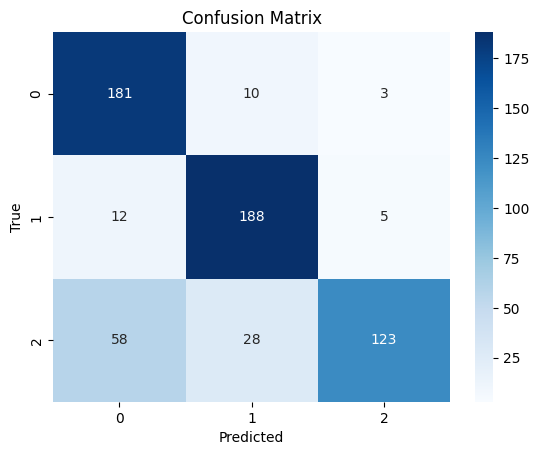

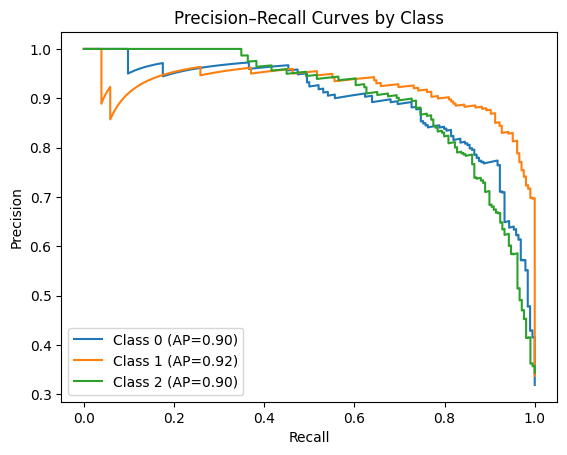

In [ ]:
# Step 6. Evaluate model performance: Precision and Average Precision
import numpy as np
from sklearn.metrics import precision_score, average_precision_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Collect predictions and true labels from the validation dataset
y_true = []
y_pred_probs = []
y_pred_classes = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(probs)
    y_pred_classes.extend(preds)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.array(y_pred_classes)

# 2️⃣ Precision at fixed threshold (predicted class)
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f"Precision (weighted): {precision:.3f}")

# 3️⃣ Average Precision (AP) per class + mean AP (mAP)
from sklearn.preprocessing import label_binarize
n_classes = y_pred_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

ap_per_class = []
for i in range(n_classes):
    ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    ap_per_class.append(ap)
    print(f"Class {i} Average Precision (AP): {ap:.3f}")

mAP = np.mean(ap_per_class)
print(f"\nMean Average Precision (mAP): {mAP:.3f}")

# 4️⃣ Optional: classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 5️⃣ Optional: Precision–Recall curves for each class
for i in range(n_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall_vals, precision_vals, label=f'Class {i} (AP={ap_per_class[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves by Class')
plt.legend()
plt.show()


In [3]:
# ============================================
# PART 6: Evaluate and Check Class Balance
# ============================================

# Evaluate on test set
print("\n📊 Test Set Evaluation:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

# Check class distribution
print("\n📈 Checking class distribution...")
train_labels = []
for images, labels in train_ds: # Iterate through batches
    train_labels.extend(labels.numpy()) # Collect labels from each batch


import numpy as np
train_labels = np.array(train_labels)
unique, counts = np.unique(train_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution:", class_distribution)
total = sum(counts)
for cls, count in class_distribution.items():
    print(f"  Class {cls}: {count} samples ({count/total*100:.1f}%)")

# Check if imbalanced
max_count = max(counts)
min_count = min(counts)
imbalance_ratio = max_count / min_count

if imbalance_ratio > 1.5:
    print(f"\n⚠️ WARNING: Class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("Consider using class_weight parameter in model.fit()")

    # Calculate class weights
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    print("Suggested class weights:", dict(enumerate(class_weights)))


📊 Test Set Evaluation:


NameError: name 'model' is not defined

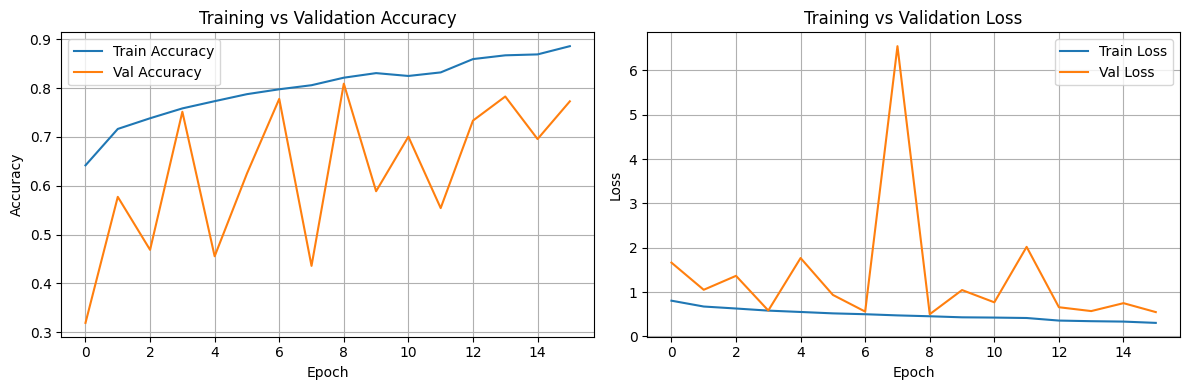


✅ Training complete!


In [ ]:
# ============================================
# PART 7: Plot Training History
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n✅ Training complete!")